# Lab 3 - Data Preprocessing & Cleaning

Data preprocessing is a predominant step in data mining and machine learning to yield highly accurate and insightful results. Greater the quality of data, greater is the reliance on the produced results. Real-world data is often **incomplete, noisy, and inconsistent**. Data preprocessing helps in increasing the quality of data by filling in missing incomplete data, smoothing noise and resolving inconsistencies.

- **Incomplete data** can occur for a number of reasons. Attributes of interest may not always be available, such as customer information for sales transaction data. Relevant data may not be recorded due to a misunderstanding, or because of equipment malfunctions.
- There are many possible reasons for **noisy data** (having incorrect attribute values). The data collection instruments used may be faulty. There may have been human or computer errors occurring at data entry. Errors in data transmission can also occur. Incorrect data may also result from inconsistencies in naming conventions or data codes used, or inconsistent formats for input fields, such as date.

There are a number of data preprocessing techniques available such as:

- **Data cleaning** can be applied to filling in missing values, remove noise, resolving inconsistencies, identifying and removing outliers in the data.
- **Data integration** merges data from multiple sources into a coherent data store, such as a data warehouse.
- **Data transformations**, such as normalization, may be applied. For example, normalization may improve the accuracy and efficiency of mining algorithms involving distance measurements.
- **Data reduction** can reduce the data size by eliminating redundant features, or clustering, for instance.

_(Adapted from: Rajan, 2020)_

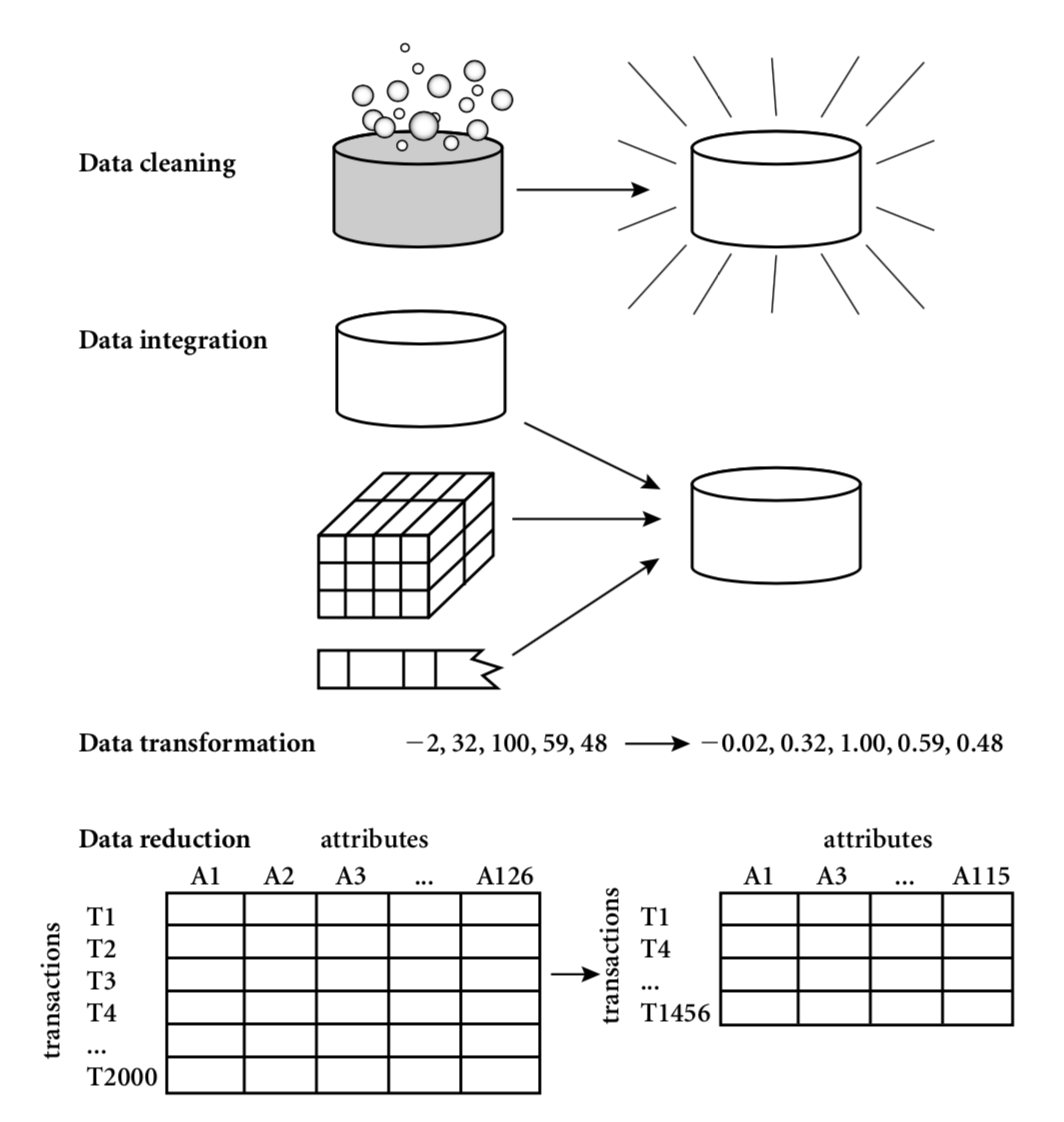

In [23]:
import pandas as pd
import numpy as np

## Data Cleaning - A Minimal Example

_(Adapted from: Riley, 2020)_

It's not uncommon to have to deal with poorly formatted data. Let's use the following dummy data as a short demonstration for some data tidying functions.

In [24]:
df = pd.DataFrame({'From_To': ['LoNDon_paris', 'MAdrid_miLAN', 'londON_StockhOlm', 
                               'Budapest_PaRis', 'Brussels_londOn'],
              'FlightNumber': [10045, np.nan, 10065, np.nan, 10085],
              'RecentDelays': [[23, 47], [], [24, 43, 87], [13], [67, 32]],
                   'Airline': ['KLM(!)', '<Air France> (12)', '(British Airways. )', 
                               '12. Air France', '"Swiss Air"']})
df

From_To  FlightNumber  RecentDelays              Airline
0      LoNDon_paris       10045.0      [23, 47]               KLM(!)
1      MAdrid_miLAN           NaN            []    <Air France> (12)
2  londON_StockhOlm       10065.0  [24, 43, 87]  (British Airways. )
3    Budapest_PaRis           NaN          [13]       12. Air France
4   Brussels_londOn       10085.0      [67, 32]          "Swiss Air"

Some values in the the **FlightNumber** column are missing (they are `NaN`). These numbers are meant to increase by 10 with each row so 10055 and 10075 need to be put in place. We'll modify `df` to fill in these missing numbers through interpolation and change the column's data type to integer (instead of float).

In [25]:
df['FlightNumber'] = df['FlightNumber'].interpolate().astype(int)
df

From_To  FlightNumber  RecentDelays              Airline
0      LoNDon_paris         10045      [23, 47]               KLM(!)
1      MAdrid_miLAN         10055            []    <Air France> (12)
2  londON_StockhOlm         10065  [24, 43, 87]  (British Airways. )
3    Budapest_PaRis         10075          [13]       12. Air France
4   Brussels_londOn         10085      [67, 32]          "Swiss Air"

**39.** The **From\_To** column would be better as two separate columns! Split each string on the underscore delimiter `_` to give a new temporary DataFrame called 'temp' with the correct values. Assign the correct column names 'From' and 'To' to this temporary DataFrame. 

In [26]:
temp = df.From_To.str.split('_', expand=True)
temp

0          1
0    LoNDon      paris
1    MAdrid      miLAN
2    londON  StockhOlm
3  Budapest      PaRis
4  Brussels     londOn

Let's assign meaningful column names.

In [27]:
temp.columns = ['From', 'To']
temp

From         To
0    LoNDon      paris
1    MAdrid      miLAN
2    londON  StockhOlm
3  Budapest      PaRis
4  Brussels     londOn

The capitalisation of the city names is all mixed up in this temporary DataFrame. We'll standardise the strings so that only the first letter is uppercase (e.g. "londON" should become "London".)

In [28]:
temp['From'] = temp['From'].str.capitalize()
temp['To'] = temp['To'].str.capitalize()
temp

From         To
0    London      Paris
1    Madrid      Milan
2    London  Stockholm
3  Budapest      Paris
4  Brussels     London

We'll delete the now redundant From_To column and add our processed columns from `temp`.

In [29]:
df = df.drop('From_To', axis=1)
df = df.join(temp)
df

FlightNumber  RecentDelays              Airline      From         To
0         10045      [23, 47]               KLM(!)    London      Paris
1         10055            []    <Air France> (12)    Madrid      Milan
2         10065  [24, 43, 87]  (British Airways. )    London  Stockholm
3         10075          [13]       12. Air France  Budapest      Paris
4         10085      [67, 32]          "Swiss Air"  Brussels     London

In the **Airline** column, there are some extra symbols, puctuation and whitespaces around the airline names. For the sake of consistency, we'll need to extract just the airline name from each record. E.g. `'(British Airways. )'` should become `'British Airways'`.

We use regular expressions (regex) to extract text based on a certain pattern. In this case, the airline name can consist of one or more of any lower case letter `a-z`, any upper case letter `A-Z`, whitespace(s) between words `\s`. So, the regex to match airline names is `[a-zA-Z\s]+`. Since that is the substring we want to capture, we encapsulate it in brackets as seen below (referred to as a _capturing group_).

_See [regexr](https://regexr.com/) to experiment with and learn regex._

In [30]:
# expand=False so we always get a series, instead of the result being expanded to a dataframe
# using .strip() gets rid of any leading/trailing spaces
df['Airline'] = df['Airline'].str.extract('([a-zA-Z\\s]+)', expand=False).str.strip()
df

FlightNumber  RecentDelays          Airline      From         To
0         10045      [23, 47]              KLM    London      Paris
1         10055            []       Air France    Madrid      Milan
2         10065  [24, 43, 87]  British Airways    London  Stockholm
3         10075          [13]       Air France  Budapest      Paris
4         10085      [67, 32]        Swiss Air  Brussels     London

In the **RecentDelays** column, the values have been entered into the DataFrame as a list. We would like each first value in its own column, each second value in its own column, and so on. If there isn't an Nth value, the value should be NaN.

Let's expand the Series of lists into a new DataFrame named 'delays', rename the columns 'delay_1', 'delay_2', etc. and then replace the unwanted RecentDelays column in `df` with 'delays'.

In [31]:
# there are several ways to do this, but the following approach is possibly the simplest

delays = df['RecentDelays'].apply(pd.Series)

delays.columns = ['delay_{}'.format(n) for n in range(1, len(delays.columns)+1)]

delays

delay_1  delay_2  delay_3
0     23.0     47.0      NaN
1      NaN      NaN      NaN
2     24.0     43.0     87.0
3     13.0      NaN      NaN
4     67.0     32.0      NaN

In [32]:
df = df.drop('RecentDelays', axis=1).join(delays)

# The DataFrame should look much better now
df

FlightNumber          Airline      From         To  delay_1  delay_2  \
0         10045              KLM    London      Paris     23.0     47.0   
1         10055       Air France    Madrid      Milan      NaN      NaN   
2         10065  British Airways    London  Stockholm     24.0     43.0   
3         10075       Air France  Budapest      Paris     13.0      NaN   
4         10085        Swiss Air  Brussels     London     67.0     32.0   

   delay_3  
0      NaN  
1      NaN  
2     87.0  
3      NaN  
4      NaN

As a final touch, since flights that were not delayed have `NaN` recorded, we can replace the `NaN` (i.e. missing) values with 0 (indicating a delay of 0 minutes, i.e. no delay).

In [33]:
# loc can be used like so for dataframes to select a particular subset of a dataset:
# df.loc[row_label/boolean_mask, col_label]

df.loc[:, 'delay_1':'delay_3'] = df.loc[:, 'delay_1':'delay_3'].fillna(0)
df

FlightNumber          Airline      From         To  delay_1  delay_2  \
0         10045              KLM    London      Paris     23.0     47.0   
1         10055       Air France    Madrid      Milan      0.0      0.0   
2         10065  British Airways    London  Stockholm     24.0     43.0   
3         10075       Air France  Budapest      Paris     13.0      0.0   
4         10085        Swiss Air  Brussels     London     67.0     32.0   

   delay_3  
0      0.0  
1      0.0  
2     87.0  
3      0.0  
4      0.0

## Data Preprocessing - Billboard Dataset

"The Billboard Hot 100 is the music industry standard record chart in the United States for songs, published weekly by Billboard magazine. Chart rankings are based on sales, radio play, and online streaming in the United States." [Wikipedia](https://en.wikipedia.org/wiki/Billboard_Hot_100)

This dataset contains the top hit songs on the Billboard Hot 100 list from 1999 to 2001.

In [37]:
try:
    df_billboard = pd.read_csv('../data/billboard.csv')
except FileNotFoundError:
    df_billboard = pd.read_csv('https://raw.githubusercontent.com/GUC-DM/W2024/main/data/billboard.csv')

df_billboard

year      artist.inverted                                  track  time  \
0    2000      Destiny's Child               Independent Women Part I  3:38   
1    2000              Santana                           Maria, Maria  4:18   
2    2000        Savage Garden                     I Knew I Loved You  4:07   
3    2000              Madonna                                  Music  3:45   
4    2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   
..    ...                  ...                                    ...   ...   
312  2000     Ghostface Killah                       Cherchez LaGhost  3:04   
313  2000          Smith, Will                            Freakin' It  3:58   
314  2000        Zombie Nation                          Kernkraft 400  3:30   
315  2000       Eastsidaz, The                               Got Beef  3:58   
316  2000               Fragma                         Toca's Miracle  3:22   

    genre date.entered date.peaked  x1st.week  x2nd.week  x3rd.week  ...  \
0    Rock   2000-09-23  2000-11-18         78       63.0       49.0  ...   
1    Rock   2000-02-12  2000-04-08         15        8.0        6.0  ...   
2    Rock   1999-10-23  2000-01-29         71       48.0       43.0  ...   
3    Rock   2000-08-12  2000-09-16         41       23.0       18.0  ...   
4    Rock   2000-08-05  2000-10-14         57       47.0       45.0  ...   
..    ...          ...         ...        ...        ...        ...  ...   
312   R&B   2000-08-05  2000-08-05         98        NaN        NaN  ...   
313   Rap   2000-02-12  2000-02-12         99       99.0       99.0  ...   
314  Rock   2000-09-02  2000-09-02         99       99.0        NaN  ...   
315   Rap   2000-07-01  2000-07-01         99       99.0        NaN  ...   
316   R&B   2000-10-28  2000-10-28         99        NaN        NaN  ...   

     x67th.week  x68th.week  x69th.week  x70th.week  x71st.week  x72nd.week  \
0           NaN         NaN         NaN         NaN         NaN         NaN   
1           NaN         NaN         NaN         NaN         NaN         NaN   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
312         NaN         NaN         NaN         NaN         NaN         NaN   
313         NaN         NaN         NaN         NaN         NaN         NaN   
314         NaN         NaN         NaN         NaN         NaN         NaN   
315         NaN         NaN         NaN         NaN         NaN         NaN   
316         NaN         NaN         NaN         NaN         NaN         NaN   

     x73rd.week  x74th.week  x75th.week  x76th.week  
0           NaN         NaN         NaN         NaN  
1           NaN         NaN         NaN         NaN  
2           NaN         NaN         NaN         NaN  
3           NaN         NaN         NaN         NaN  
4           NaN         NaN         NaN         NaN  
..          ...         ...         ...         ...  
312         NaN         NaN         NaN         NaN  
313         NaN         NaN         NaN         NaN  
314         NaN         NaN         NaN         NaN  
315         NaN         NaN         NaN         NaN  
316         NaN         NaN         NaN         NaN  

[317 rows x 83 columns]

***What is wrong with the above dataset?***

Each column header should represent a variable, not a value. Let's use the `melt` function to fix the general structure of the dataframe.

In [38]:
#Which columns do I want to keep, as they are? 
id_vars=['year', 'artist.inverted', 'track', 'time', 'genre', 'date.entered', 'date.peaked']
df_billboard = pd.melt(df_billboard, id_vars=id_vars, var_name='Week', value_name='Rank')
df_billboard

year      artist.inverted                                  track  time  \
0      2000      Destiny's Child               Independent Women Part I  3:38   
1      2000              Santana                           Maria, Maria  4:18   
2      2000        Savage Garden                     I Knew I Loved You  4:07   
3      2000              Madonna                                  Music  3:45   
4      2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   
...     ...                  ...                                    ...   ...   
24087  2000     Ghostface Killah                       Cherchez LaGhost  3:04   
24088  2000          Smith, Will                            Freakin' It  3:58   
24089  2000        Zombie Nation                          Kernkraft 400  3:30   
24090  2000       Eastsidaz, The                               Got Beef  3:58   
24091  2000               Fragma                         Toca's Miracle  3:22   

      genre date.entered date.peaked        Week  Rank  
0      Rock   2000-09-23  2000-11-18   x1st.week  78.0  
1      Rock   2000-02-12  2000-04-08   x1st.week  15.0  
2      Rock   1999-10-23  2000-01-29   x1st.week  71.0  
3      Rock   2000-08-12  2000-09-16   x1st.week  41.0  
4      Rock   2000-08-05  2000-10-14   x1st.week  57.0  
...     ...          ...         ...         ...   ...  
24087   R&B   2000-08-05  2000-08-05  x76th.week   NaN  
24088   Rap   2000-02-12  2000-02-12  x76th.week   NaN  
24089  Rock   2000-09-02  2000-09-02  x76th.week   NaN  
24090   Rap   2000-07-01  2000-07-01  x76th.week   NaN  
24091   R&B   2000-10-28  2000-10-28  x76th.week   NaN  

[24092 rows x 9 columns]

If we inspect the current dataframe. We find that it is structured in a better way than before. 

However, the ***Week*** column looks a bit ugly!

Let's try to place only the week number in that column without the extras surronding it.

In [40]:
df_billboard['Week'] = df_billboard['Week'].str.extract(r'(\d+)', expand=False) # expand determines whether a series or a dataframe is returned


Now let's inspect the ***Week*** column in the dataframe.

In [41]:
df_billboard.head()

year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre date.entered date.peaked Week  Rank  
0  Rock   2000-09-23  2000-11-18    1  78.0  
1  Rock   2000-02-12  2000-04-08    1  15.0  
2  Rock   1999-10-23  2000-01-29    1  71.0  
3  Rock   2000-08-12  2000-09-16    1  41.0  
4  Rock   2000-08-05  2000-10-14    1  57.0

Next, let's try to find the date at which the song ranked the number that is shown per row.

To do that let's first think of the equation that is going to get us the relevant date at which the song ranked the *rth*.

In [42]:
# Let's make sure that the Week column is numeric.
df_billboard['Week'] = df_billboard['Week'].astype(int)

df_billboard['date.entered'] = pd.to_datetime(df_billboard['date.entered'] )
df_billboard['date.peaked'] = pd.to_datetime(df_billboard['date.peaked'] )

# date_at_current_rank = date.entered + week
df_billboard['Rank Date'] = df_billboard['date.entered'] + pd.to_timedelta(df_billboard['Week'], unit='W') 
df_billboard.head()

year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre date.entered date.peaked  Week  Rank  Rank Date  
0  Rock   2000-09-23  2000-11-18     1  78.0 2000-09-30  
1  Rock   2000-02-12  2000-04-08     1  15.0 2000-02-19  
2  Rock   1999-10-23  2000-01-29     1  71.0 1999-10-30  
3  Rock   2000-08-12  2000-09-16     1  41.0 2000-08-19  
4  Rock   2000-08-05  2000-10-14     1  57.0 2000-08-12

*Timedeltas are absolute differences in times, expressed in difference units (e.g. days, hours, minutes, seconds). This method converts an argument from a recognized timedelta format / value into a Timedelta type.*


***What is the problem with the calculation above?***

To make the `'Rank Date'` column indicate the week starting X like the other dates and not the end of the week, we have to subtract 1 week from its value.

In [45]:
df_billboard['Rank Date'] = pd.to_datetime(df_billboard['date.entered'] )+ pd.to_timedelta(df_billboard['Week'], unit='W') - pd.DateOffset(weeks=1)

In [50]:
df_billboard.head()

year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre date.entered date.peaked  Week  Rank  Rank Date  
0  Rock   2000-09-23  2000-11-18     1  78.0 2000-09-23  
1  Rock   2000-02-12  2000-04-08     1  15.0 2000-02-12  
2  Rock   1999-10-23  2000-01-29     1  71.0 1999-10-23  
3  Rock   2000-08-12  2000-09-16     1  41.0 2000-08-12  
4  Rock   2000-08-05  2000-10-14     1  57.0 2000-08-05

Keeping just the necessary columns

In [51]:
df_billboard = df_billboard[['year','artist.inverted','track','time','genre','Rank','Rank Date']]

In [52]:
df_billboard.head()

year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre  Rank  Rank Date  
0  Rock  78.0 2000-09-23  
1  Rock  15.0 2000-02-12  
2  Rock  71.0 1999-10-23  
3  Rock  41.0 2000-08-12  
4  Rock  57.0 2000-08-05

Renaming columns in the dataset

In [53]:
df_billboard = df_billboard.rename(columns={'year':'Year','artist.inverted':'Artist LN-FN','track':'Track','time':'Time','genre':'Genre'})
df_billboard

Year         Artist LN-FN                                  Track  Time  \
0      2000      Destiny's Child               Independent Women Part I  3:38   
1      2000              Santana                           Maria, Maria  4:18   
2      2000        Savage Garden                     I Knew I Loved You  4:07   
3      2000              Madonna                                  Music  3:45   
4      2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   
...     ...                  ...                                    ...   ...   
24087  2000     Ghostface Killah                       Cherchez LaGhost  3:04   
24088  2000          Smith, Will                            Freakin' It  3:58   
24089  2000        Zombie Nation                          Kernkraft 400  3:30   
24090  2000       Eastsidaz, The                               Got Beef  3:58   
24091  2000               Fragma                         Toca's Miracle  3:22   

      Genre  Rank  Rank Date  
0      Rock  78.0 2000-09-23  
1      Rock  15.0 2000-02-12  
2      Rock  71.0 1999-10-23  
3      Rock  41.0 2000-08-12  
4      Rock  57.0 2000-08-05  
...     ...   ...        ...  
24087   R&B   NaN 2002-01-12  
24088   Rap   NaN 2001-07-21  
24089  Rock   NaN 2002-02-09  
24090   Rap   NaN 2001-12-08  
24091   R&B   NaN 2002-04-06  

[24092 rows x 7 columns]

In the above dataframe, there are *NaN* values in Rank when it is no longer on the top song list. We'll remove them from our dataset.

In [54]:
# Showing how many values are missing per column
df_billboard.isna().sum()

Year                0
Artist LN-FN        0
Track               0
Time                0
Genre               0
Rank            18785
Rank Date           0
dtype: int64

In [55]:
# Boolean mask to filter to rows that have at least 1 missing value 
df_billboard.isna().sum(axis=1) > 0

0        False
1        False
2        False
3        False
4        False
         ...  
24087     True
24088     True
24089     True
24090     True
24091     True
Length: 24092, dtype: bool

In [56]:
df_billboard.loc[df_billboard.isna().sum(axis=1) > 0]

Year      Artist LN-FN                  Track  Time Genre  Rank  \
588    2000   Estefan, Gloria  No Me Dejes De Querer  3:25  Rock   NaN   
618    2000         Anastacia         I'm Outta Love  4:01   Pop   NaN   
628    2000          Master P                Souljas  3:33   Rap   NaN   
629    2000  Ghostface Killah       Cherchez LaGhost  3:04   R&B   NaN   
633    2000            Fragma         Toca's Miracle  3:22   R&B   NaN   
...     ...               ...                    ...   ...   ...   ...   
24087  2000  Ghostface Killah       Cherchez LaGhost  3:04   R&B   NaN   
24088  2000       Smith, Will            Freakin' It  3:58   Rap   NaN   
24089  2000     Zombie Nation          Kernkraft 400  3:30  Rock   NaN   
24090  2000    Eastsidaz, The               Got Beef  3:58   Rap   NaN   
24091  2000            Fragma         Toca's Miracle  3:22   R&B   NaN   

       Rank Date  
588   2000-06-17  
618   2000-04-08  
628   2000-11-25  
629   2000-08-12  
633   2000-11-04  
...          ...  
24087 2002-01-12  
24088 2001-07-21  
24089 2002-02-09  
24090 2001-12-08  
24091 2002-04-06  

[18785 rows x 7 columns]

In [57]:
df_billboard = df_billboard.dropna()
df_billboard

Year         Artist LN-FN                                  Track  Time  \
0      2000      Destiny's Child               Independent Women Part I  3:38   
1      2000              Santana                           Maria, Maria  4:18   
2      2000        Savage Garden                     I Knew I Loved You  4:07   
3      2000              Madonna                                  Music  3:45   
4      2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   
...     ...                  ...                                    ...   ...   
19663  2000             Lonestar                                 Amazed  4:25   
19700  2000                Creed                                 Higher  5:16   
19980  2000             Lonestar                                 Amazed  4:25   
20017  2000                Creed                                 Higher  5:16   
20334  2000                Creed                                 Higher  5:16   

         Genre  Rank  Rank Date  
0         Rock  78.0 2000-09-23  
1         Rock  15.0 2000-02-12  
2         Rock  71.0 1999-10-23  
3         Rock  41.0 2000-08-12  
4         Rock  57.0 2000-08-05  
...        ...   ...        ...  
19663  Country  45.0 2000-08-12  
19700     Rock  50.0 2000-11-18  
19980  Country  50.0 2000-08-19  
20017     Rock  50.0 2000-11-25  
20334     Rock  49.0 2000-12-02  

[5307 rows x 7 columns]

## References & Acknowledgements

- Contributors to Wikimedia projects (2021, January). Billboard Hot 100 - Wikipedia. Retrieved from https://en.wikipedia.org/w/index.php?title=Billboard_Hot_100&oldid=998597815
- Hould, J. N. (2016). Tidy Data in Python, GitHub. Available at: https://www.github.com/nickhould/tidy-data-python
- Rajan, S. (2020). Data preprocessing for House Price Prediction. Kaggle. Available at: https://www.kaggle.com/srivignesh/data-preprocessing-for-house-price-prediction
- Riley, A. (2020). 100 pandas puzzles. GitHub. Available at: https://github.com/ajcr/100-pandas-puzzles